Problem 1: Linear Regression

You are hired by a company Gem Stones co ltd, which is a cubic zirconia manufacturer.
You are provided with the dataset containing the prices and other attributes of almost 27,000 
cubic zirconia (which is an inexpensive diamond alternative with many of the same qualities as a diamond).
The company is earning different profits on different prize slots. You have to help the company in predicting
the price for the stone on the bases of the details given in the dataset so it can distinguish between higher 
profitable stones and lower profitable stones so as to have better profit share. Also, provide them with the 
best 5 attributes that are most important.

# Importing all required Libraries


In [352]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading the Data

In [353]:
# reading the CSV file into pandas dataframe
df = pd.read_csv("cubic_zirconia.csv")  

# Checking the data

In [354]:
df.shape

(26967, 11)

In [355]:
df.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
x             float64
y             float64
z             float64
price           int64
dtype: object

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26967 entries, 0 to 26966
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  26967 non-null  int64  
 1   carat       26967 non-null  float64
 2   cut         26967 non-null  object 
 3   color       26967 non-null  object 
 4   clarity     26967 non-null  object 
 5   depth       26270 non-null  float64
 6   table       26967 non-null  float64
 7   x           26967 non-null  float64
 8   y           26967 non-null  float64
 9   z           26967 non-null  float64
 10  price       26967 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 2.3+ MB


price is the target variable while all others are the predictors. 
Out of the 10 columns, 3 are object type, while remaining 7 are int,float. 
Nominal variables are 3: cut,color and clarity 
Numeric variables are 7: Unnamed: 0, carat,depth,table,x,y,z
It seems missing values are present in the dataset.

In [357]:
# variable Unnamed is not necessary for model building, hence we drop them
df=df.drop("Unnamed: 0", axis=1)

# Checking Summary statistic

In [358]:
df.describe(include="all")

,carat,cut,color,clarity,depth,table,x,y,z,price
count,26967.000000,26967,26967,26967,26270.000000,26967.000000,26967.000000,26967.000000,26967.000000,26967.000000
unique,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,10816,5661,6571,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.798375,NaN,NaN,NaN,61.745147,57.456080,5.729854,5.733569,3.538057,3939.518115
std,0.477745,NaN,NaN,NaN,1.412860,2.232068,1.128516,1.166058,0.720624,4024.864666
min,0.200000,NaN,NaN,NaN,50.800000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,0.400000,NaN,NaN,NaN,61.000000,56.000000,4.710000,4.710000,2.900000,945.000000
50%,0.700000,NaN,NaN,NaN,61.800000,57.000000,5.690000,5.710000,3.520000,2375.000000
75%,1.050000,NaN,NaN,NaN,62.500000,59.000000,6.550000,6.540000,4.040000,5360.000000


In [359]:
df.skew()

carat    1.116481
depth   -0.028618
table    0.765758
x        0.387986
y        3.850189
z        2.568257
price    1.618550
dtype: float64

# check for the values which are equal to zero

In [360]:
print(((df.iloc[:,:10])== 0).sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          3
y          3
z          9
price      0
dtype: int64


In [361]:
# replace '0' with nan values
for i in range(1,10):
    df.iloc[:, i].replace(0, np.nan, inplace=True)

# Check for missing values in any column


In [362]:
df.isnull().sum()

carat        0
cut          0
color        0
clarity      0
depth      697
table        0
x            3
y            3
z            9
price        0
dtype: int64

There are more number of null values for variable 'depth' whereas 'x','y','z' variables have very less null values. 

In [363]:
df[df.isnull().any(axis=1)]

,carat,cut,color,clarity,depth,table,x,y,z,price
26,0.34,Ideal,D,SI1,NaN,57.0,4.50,4.44,2.74,803
86,0.74,Ideal,E,SI2,NaN,59.0,5.92,5.97,3.52,2501
117,1.00,Premium,F,SI1,NaN,59.0,6.40,6.36,4.00,5292
148,1.11,Premium,E,SI2,NaN,61.0,6.66,6.61,4.09,4177
163,1.00,Very Good,F,VS2,NaN,55.0,6.39,6.44,3.99,6340
...,...,...,...,...,...,...,...,...,...,...
26848,1.22,Very Good,H,VS1,NaN,59.0,6.91,6.85,4.29,7673
26854,1.29,Premium,I,VS2,NaN,58.0,7.12,7.03,4.27,6321
26879,0.51,Very Good,E,SI1,NaN,58.0,5.10,5.13,3.12,1343
26923,0.51,Ideal,D,VS2,NaN,57.0,5.12,5.09,3.18,1882


# Imputing missing values

In [364]:
#continuous variables
continuous_column = ['carat','depth','table','x','y','z']

From above information, instead of dropping 'huge' values of 'depth' which leads to loss of other valuable information 
for predicting 'price', we can impute with median. Also, variables 'x','y','z' tells about length, width and height 
of zirconia which are important for the analysis. Hence we impute all null values with median

In [365]:
df[continuous_column] = df[continuous_column].apply(lambda x: x.fillna(x.median()),axis=0)


In [366]:
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
x          0
y          0
z          0
price      0
dtype: int64

### Checking for duplicates

In [367]:
# Are there any duplicates ?
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df[dups]

Number of duplicate rows = 34


,carat,cut,color,clarity,depth,table,x,y,z,price
4756,0.35,Premium,J,VS1,62.4,58.0,5.67,5.64,3.53,949
6215,0.71,Good,F,SI2,64.1,60.0,5.69,5.71,3.52,2130
8144,0.33,Ideal,G,VS1,62.1,55.0,4.46,4.43,2.76,854
8919,1.52,Good,E,I1,57.3,58.0,7.53,7.42,4.28,3105
9818,0.35,Ideal,F,VS2,61.4,54.0,4.58,4.54,2.80,906
10473,0.79,Ideal,G,SI1,62.3,57.0,5.90,5.85,3.66,2898
10500,1.00,Premium,F,VVS2,60.6,54.0,6.56,6.52,3.96,8924
12894,1.21,Premium,D,SI2,62.5,57.0,6.79,6.71,4.22,6505
13547,0.43,Ideal,G,VS1,61.9,55.0,4.84,4.86,3.00,943
13783,0.79,Ideal,G,SI1,62.3,57.0,5.90,5.85,3.66,2898


In [368]:
for column in df:
    print(column,df[column].duplicated().sum())

carat 26710
cut 26962
color 26960
clarity 26959
depth 26798
table 26855
x 26437
y 26442
z 26612
price 18225


In [369]:
print('Before',df.shape)
df.drop_duplicates(inplace=True) 
print('After',df.shape)

Before (26967, 10)
After (26933, 10)


In [370]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


# Univariate Analysis

# Geting unique counts of all Nominal Variables

In [371]:
categorical_column = [col for col in df.columns if df.dtypes[col] == 'object']
for column in df[categorical_column]:
    print(column.upper(),': ',df[column].nunique())
    print(df[column].value_counts().sort_values())
    print('\n')

CUT :  5
Fair           780
Good          2435
Very Good     6027
Premium       6886
Ideal        10805
Name: cut, dtype: int64


COLOR :  7
J    1440
I    2765
D    3341
H    4095
F    4723
E    4916
G    5653
Name: color, dtype: int64


CLARITY :  8
I1       364
IF       891
VVS1    1839
VVS2    2530
VS1     4087
SI2     4564
VS2     6093
SI1     6565
Name: clarity, dtype: int64




# Visualizing Categorical Variables - Univariate Analysis

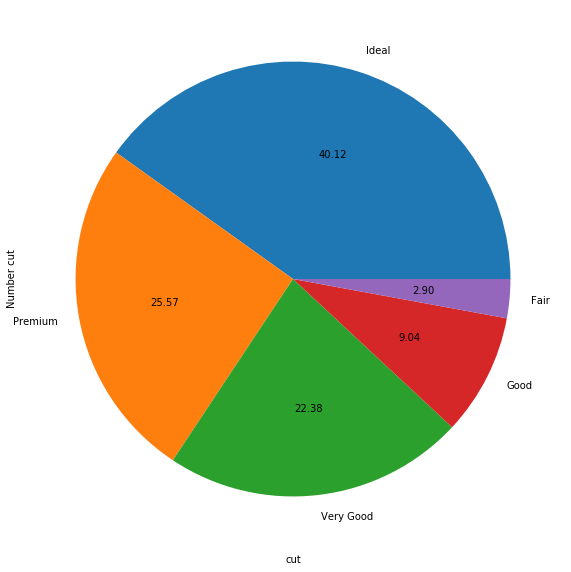

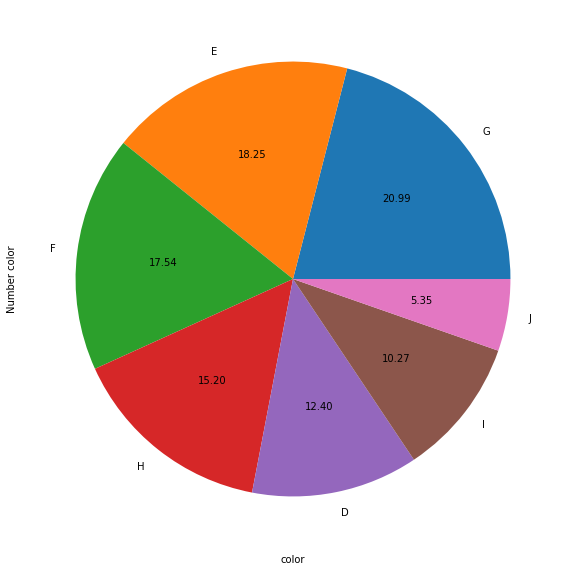

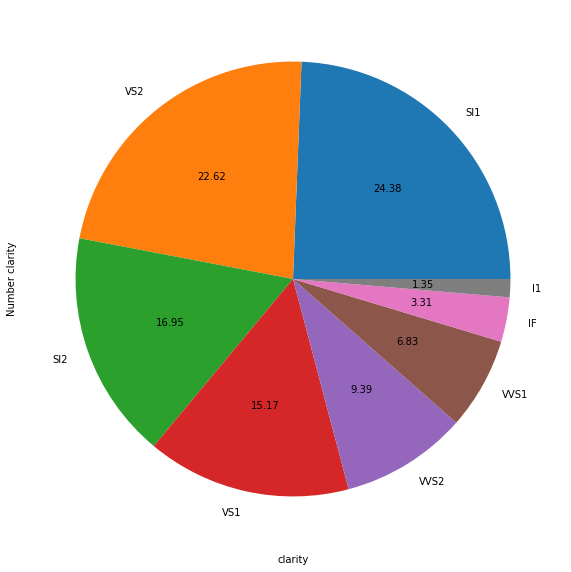

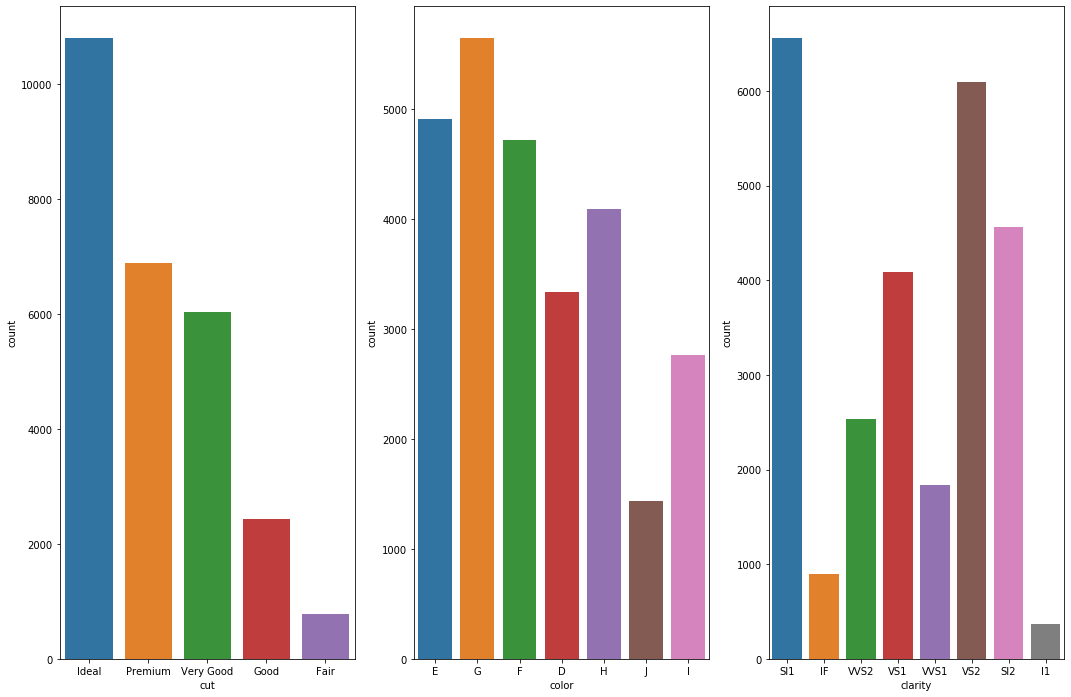

In [372]:
for col in categorical_column:
    plt.figure(figsize=(20, 15))
    df[col].value_counts().plot.pie(figsize=(10, 10), autopct='%.2f')
    plt.ylabel('Number '+ col)
    plt.xlabel(col);

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 12))
for col, ax in zip(categorical_column, axs.ravel()):
    sns.countplot(x=col, data=df, ax=ax)

Observation:
    Cut Quality is in increasing order %: Fair, Good, Very Good, Premium, Ideal.
    Color %: G being best and J being worst.
    Clarity %: SI1 being the best and I1 being the least.

# Distplot and Box plot

Text(0.5, 1.0, ' z Distribution')

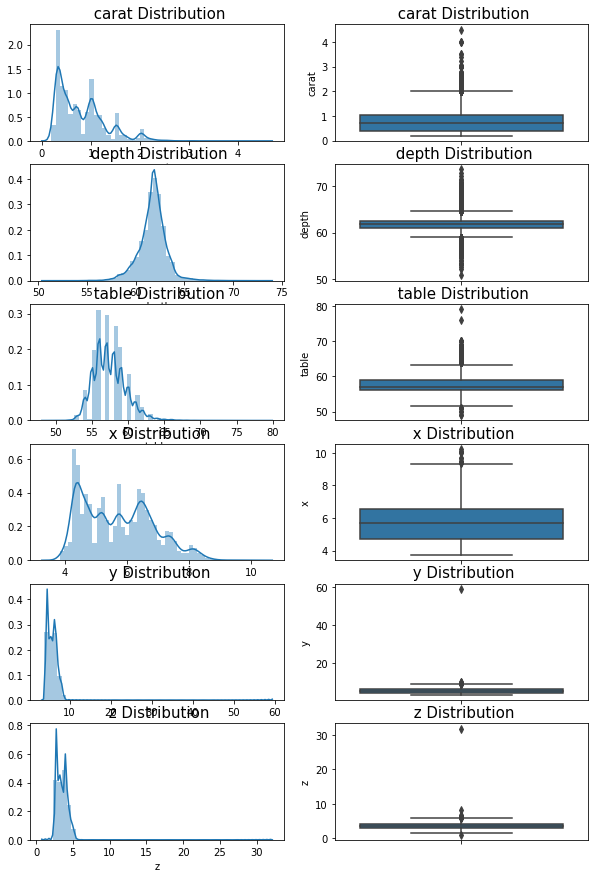

In [374]:

# continuous_column = ['carat','depth','table','x','y','z']
fig, axes = plt.subplots(nrows=6,ncols=2)
fig.set_size_inches(10, 15)
a = sns.distplot(df['carat'] , ax=axes[0][0])
a.set_title(" carat Distribution",fontsize=15)
a = sns.boxplot(df['carat'] , orient = "v" , ax=axes[0][1])
a.set_title(" carat Distribution",fontsize=15)

a = sns.distplot(df['depth'] , ax=axes[1][0])
a.set_title(" depth Distribution",fontsize=15)
a = sns.boxplot(df['depth'] , orient = "v" , ax=axes[1][1])
a.set_title(" depth Distribution",fontsize=15)

a = sns.distplot(df['table'] , ax=axes[2][0])
a.set_title(" table Distribution",fontsize=15)
a = sns.boxplot(df['table'] , orient = "v" , ax=axes[2][1])
a.set_title(" table Distribution",fontsize=15)

a = sns.distplot(df['x'] , ax=axes[3][0])
a.set_title(" x Distribution",fontsize=15)
a = sns.boxplot(df['x'] , orient = "v" , ax=axes[3][1])
a.set_title(" x Distribution",fontsize=15)

a = sns.distplot(df['y'] , ax=axes[4][0])
a.set_title(" y Distribution",fontsize=15)
a = sns.boxplot(df['y'] , orient = "v" , ax=axes[4][1])
a.set_title(" y Distribution",fontsize=15)

a = sns.distplot(df['z'] , ax=axes[5][0])
a.set_title(" z Distribution",fontsize=15)
a = sns.boxplot(df['z'] , orient = "v" , ax=axes[5][1])
a.set_title(" z Distribution",fontsize=15)

In [375]:
df.skew()

carat    1.114789
depth   -0.029475
table    0.765805
x        0.402072
y        3.886002
z        2.639943
price    1.619116
dtype: float64

In [ ]:
#left-skewed data
#depth
#right-skewed data
#rem. 6
#All continuous varaibles have outliers.

# Bivariate Analysis on Continuous Variables

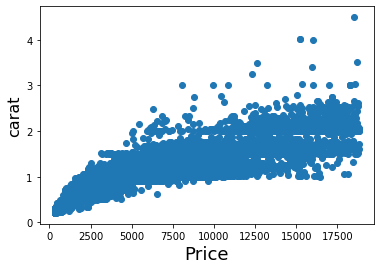

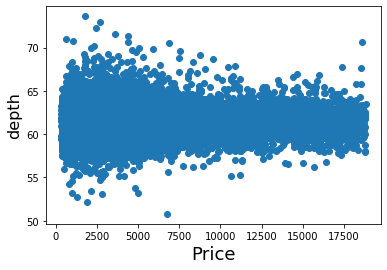

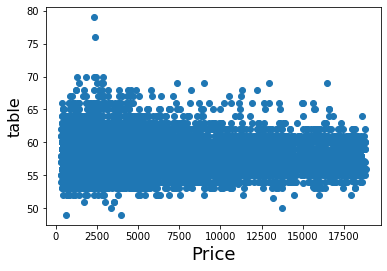

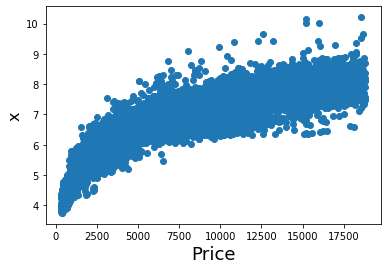

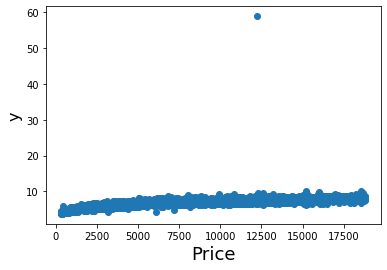

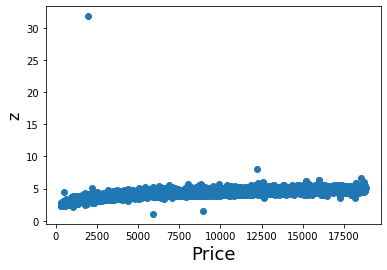

In [376]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Continuous variable

for col in continuous_column:
    fig = plt.figure()
    plt.scatter(df['price'],df[col])
    plt.xlabel('Price', fontsize=18)                         
    plt.ylabel(col, fontsize=16)

In [ ]:
# carat, x,y,z are positively correlated with price.

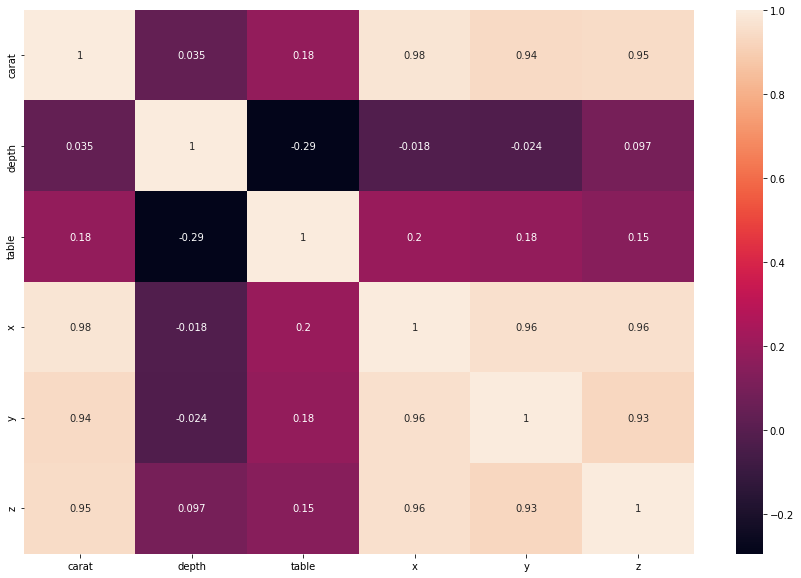

In [377]:
# Correlation matrix  
corr = df[continuous_column].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True);
plt.show()

#Below finding
# carat,x,y and z are highly correlated with each other
#As carat increases - x,y,z increases



Bivariate Analysis on Categorical Data

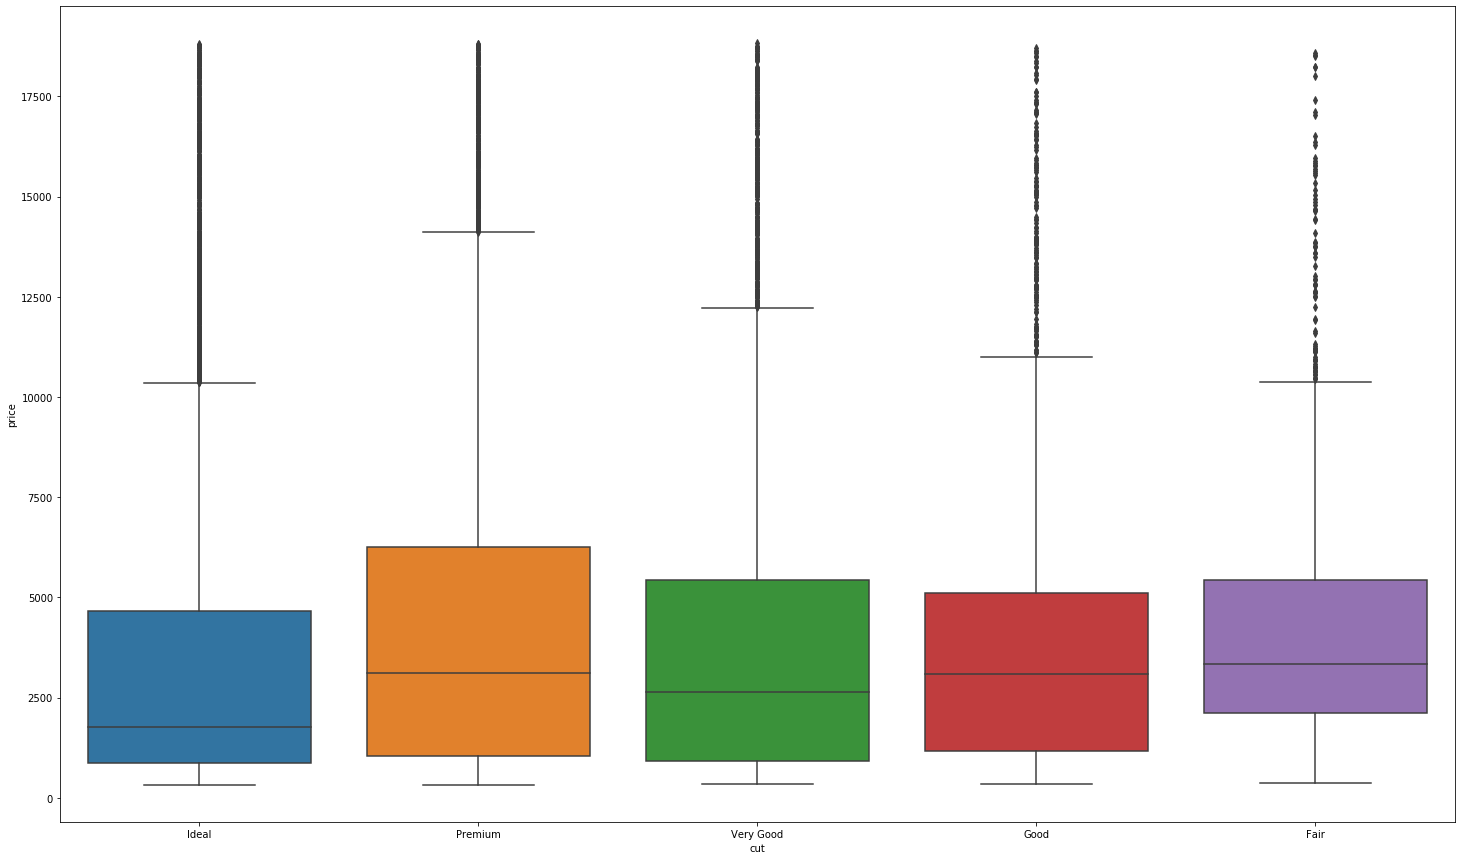

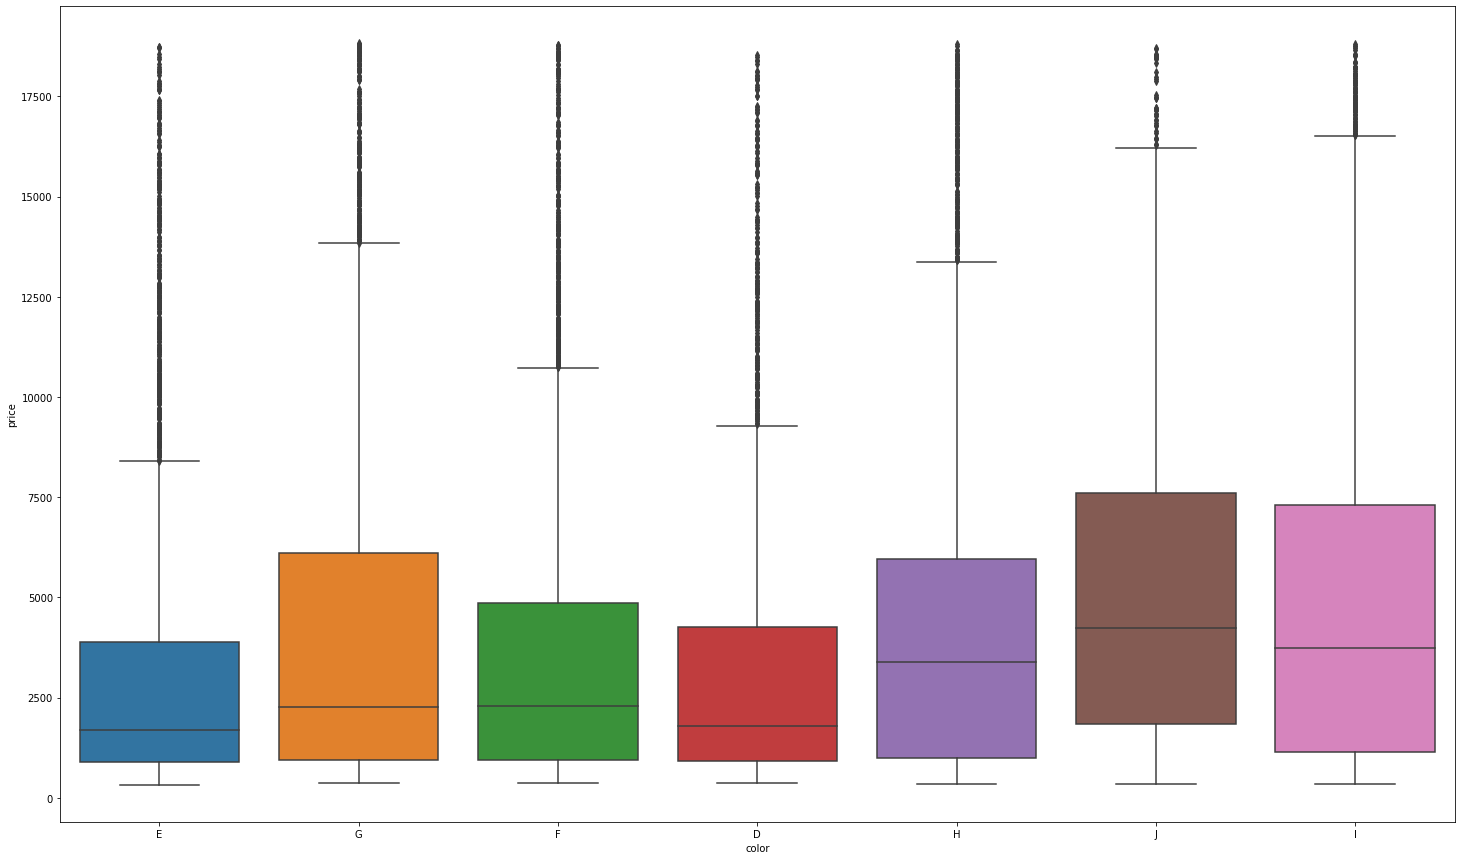

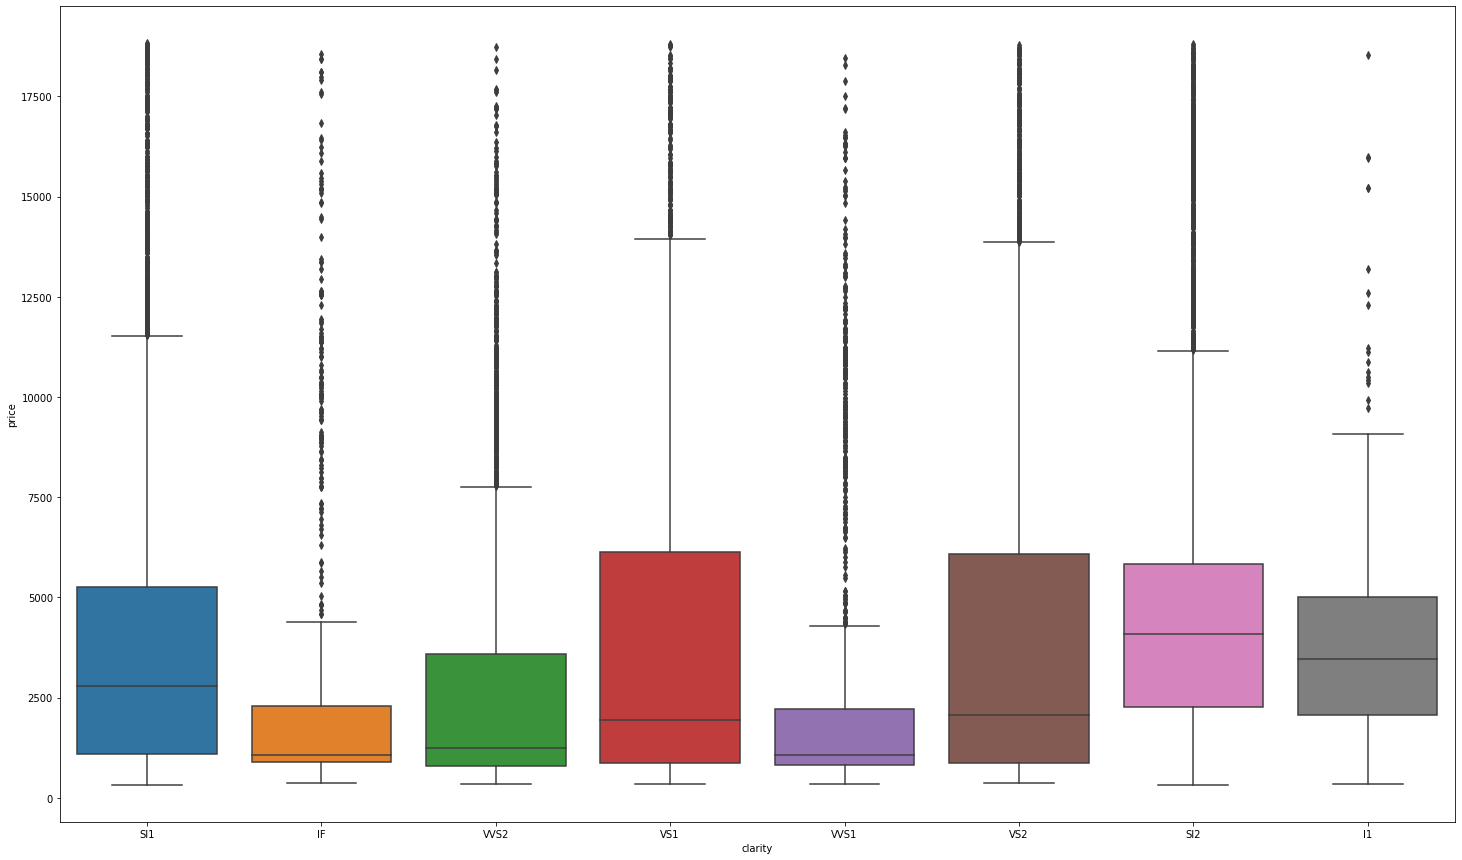

In [378]:
for col in categorical_column:
    plt.figure(figsize=(25, 15))
    sns.boxplot(x=col, y="price", data=df)

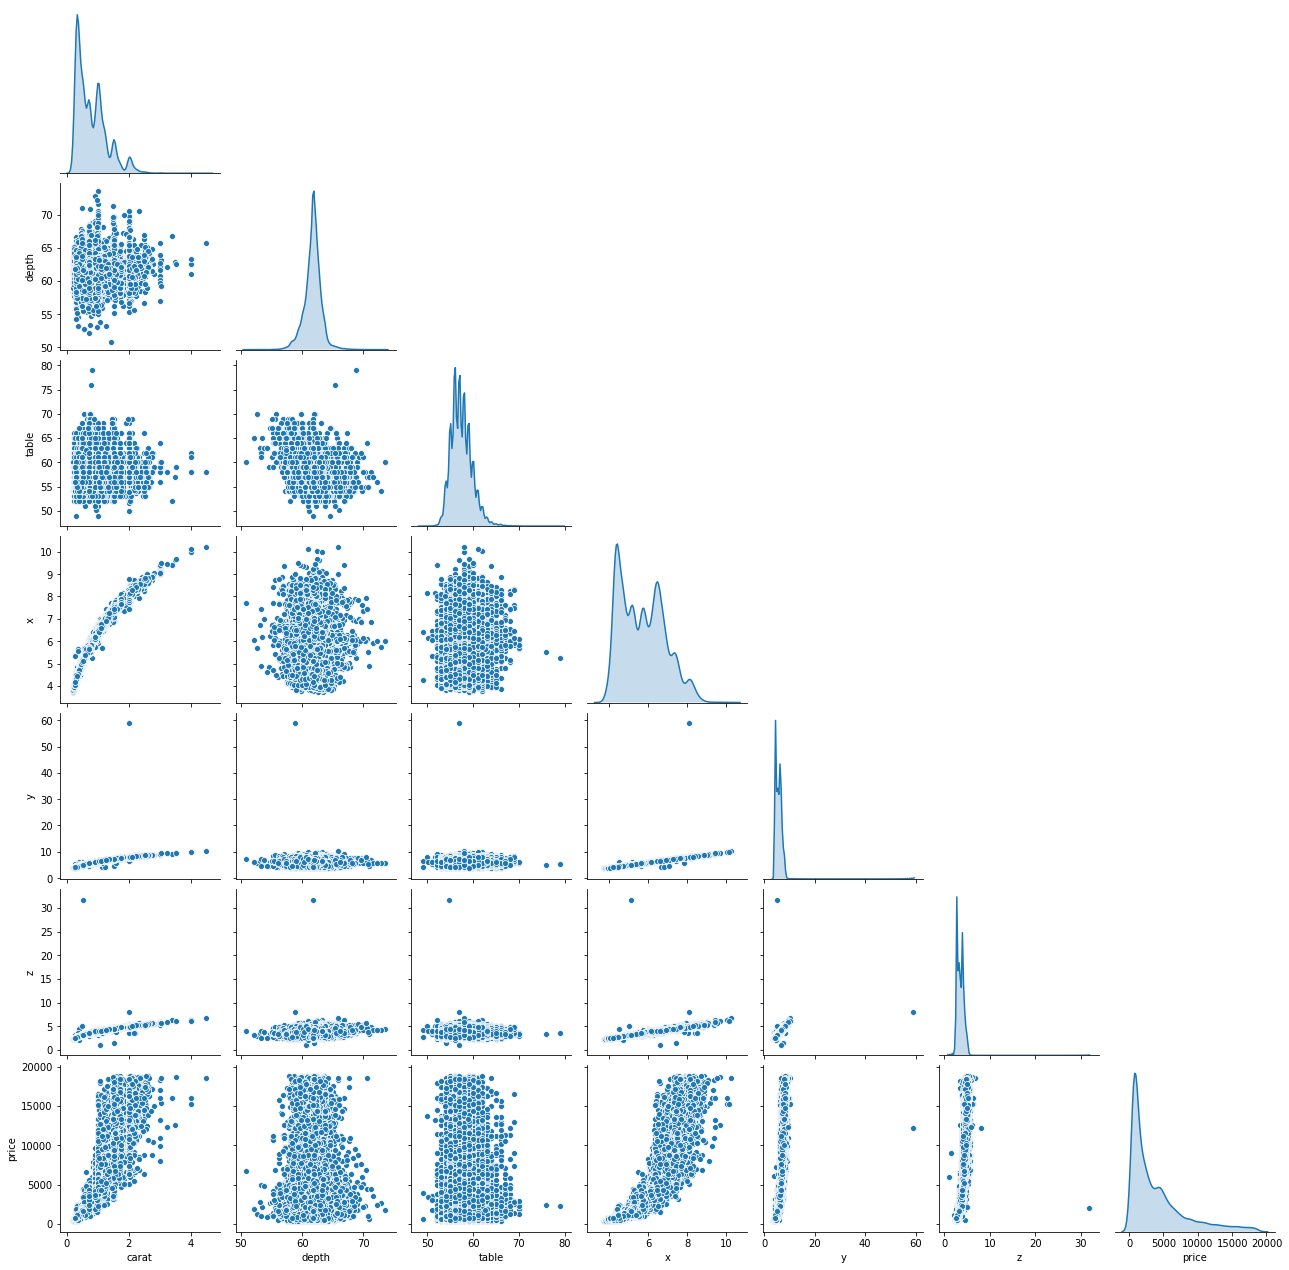

In [379]:
#Let us check for pair plots
sns.pairplot(df,diag_kind='kde',corner=True)

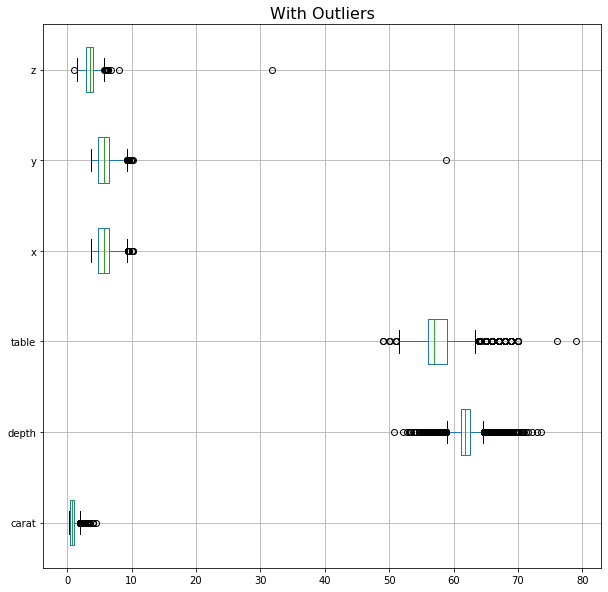

In [380]:
#outlier checks
plt.figure(figsize=(10,10))
df[continuous_column].boxplot(vert=0)
plt.title('With Outliers',fontsize=16)
plt.show()

# Imputing Outliers
Since Linear regression models are sensitive to outliers, it is better to treat them.

In [381]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [382]:
for column in df.columns:
    if df[column].dtype != 'object': 
        lr,ur=remove_outlier(df[column])
        df[column]=np.where(df[column]>ur,ur,df[column])
        df[column]=np.where(df[column]<lr,lr,df[column])

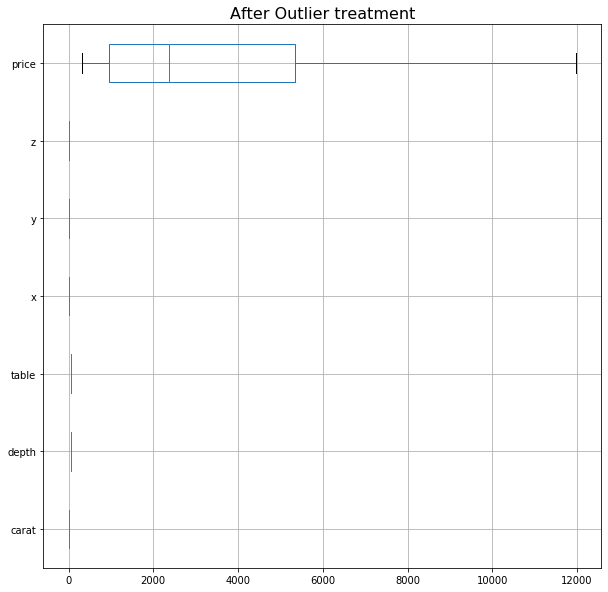

In [383]:
plt.figure(figsize=(10,10))
df.boxplot(vert=0)
plt.title('After Outlier treatment',fontsize=16)
plt.show()

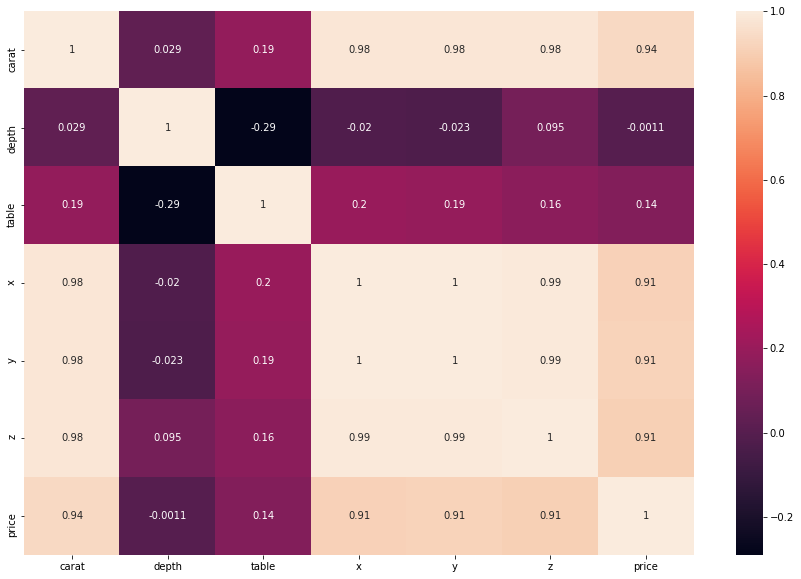

In [318]:
corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True);
plt.show()

# Converting all objects to categorical codes

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['cut']= label_encoder.fit_transform(df['cut']) 
df['color']= label_encoder.fit_transform(df['color']) 
df['clarity']= label_encoder.fit_transform(df['clarity']) 
df.head()

In [388]:
# create dictionary of ordinal to integer mapping
cut = {'Fair':1, 
            'Good':2, 
            'Ideal':3, 
            'Premium':4, 
            'Very Good':5} 
            
# apply using map
df['cut'] = df['cut'].map(cut)

color = {'D':7, 
            'E':6, 
            'F':5, 
            'G':4, 
            'H':3,
            'I':2, 
            'J':1,} 
            
# apply using map
df['color'] = df['color'].map(color)

clarity = {'FL':11, 
            'IF':10, 
            'VVS1':9, 
            'VVS2':8, 
            'VS1':7,
            'VS2':6, 
            'SI1':5,
           'SI2':4, 
            'I1':3,
            'I2':2, 
            'I3':1
          } 
            
# apply using map
df['clarity'] = df['clarity'].map(clarity)


for feature in df.columns: 
    if df[feature].dtype == 'object': 
        print('\n')
        print('feature:',feature)
        

In [392]:
df.iloc[:, 1:4].head()

,cut,color,clarity
0,3,6,5
1,4,4,10
2,5,6,8
3,3,5,7
4,3,5,9


# Rescaling the Features
It is extremely important to rescale the variables so that they have a comparable scale.

In [393]:
# Before scaling
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,3,6,5,62.1,58.0,4.27,4.29,2.66,499.0
1,0.33,4,4,10,60.8,58.0,4.42,4.46,2.70,984.0
2,0.90,5,6,8,62.2,60.0,6.04,6.12,3.78,6289.0
3,0.42,3,5,7,61.6,56.0,4.82,4.80,2.96,1082.0
4,0.31,3,5,9,60.4,59.0,4.35,4.43,2.65,779.0


In [394]:
#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
df = df.apply(normalize)

In [395]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.054795,0.50,0.833333,0.285714,0.553571,0.541667,0.096774,0.104317,0.322368,0.014854
1,0.071233,0.75,0.500000,1.000000,0.321429,0.541667,0.123656,0.134892,0.331140,0.056498
2,0.383562,1.00,0.833333,0.714286,0.571429,0.708333,0.413978,0.433453,0.567982,0.511999
3,0.120548,0.50,0.666667,0.571429,0.464286,0.375000,0.195341,0.196043,0.388158,0.064912
4,0.060274,0.50,0.666667,0.857143,0.250000,0.625000,0.111111,0.129496,0.320175,0.038896


# Multicollinearity - VIF measure
user define function for calculating vif value


In [396]:
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [397]:
# UDF for feature getting feature variable
def get_feature_variable(df,dependent_var):
    return df.loc[:,df.columns!=dependent_var], df[dependent_var]

In [453]:
# Putting feature variable to X
# Putting response variable to y

X,y = get_feature_variable(df, 'price')

In [454]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.054795,0.50,0.833333,0.285714,0.553571,0.541667,0.096774,0.104317,0.322368
1,0.071233,0.75,0.500000,1.000000,0.321429,0.541667,0.123656,0.134892,0.331140
2,0.383562,1.00,0.833333,0.714286,0.571429,0.708333,0.413978,0.433453,0.567982
3,0.120548,0.50,0.666667,0.571429,0.464286,0.375000,0.195341,0.196043,0.388158
4,0.060274,0.50,0.666667,0.857143,0.250000,0.625000,0.111111,0.129496,0.320175


In [455]:

#random_state is the seed used by the random number generator, it can be any integer.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [456]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [457]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.41690295, 0.17033907, 0.16009978, 0.10366855, 0.09201816])

In [458]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([41.7, 58.7, 74.7, 85.1, 94.3])

In [469]:
df_comp = pd.DataFrame(pca.components_,columns=list(X))
df_comp.head().T


,0,1,2,3,4
carat,0.568136,-0.059066,0.065571,0.084016,-0.208611
cut,0.020537,-0.493008,-0.689729,-0.475577,-0.227139
color,-0.279633,-0.725999,0.536950,0.103590,-0.306610
clarity,-0.250262,0.278308,-0.276843,0.433232,-0.742944
depth,0.017644,0.301096,0.342995,-0.708707,-0.313051
table,0.094103,-0.217334,-0.167652,0.218188,0.321586
x,0.453675,-0.070891,0.051849,0.095412,-0.138256
y,0.451295,-0.071839,0.047663,0.095748,-0.144197
z,0.342518,-0.029076,0.065601,0.014302,-0.132619


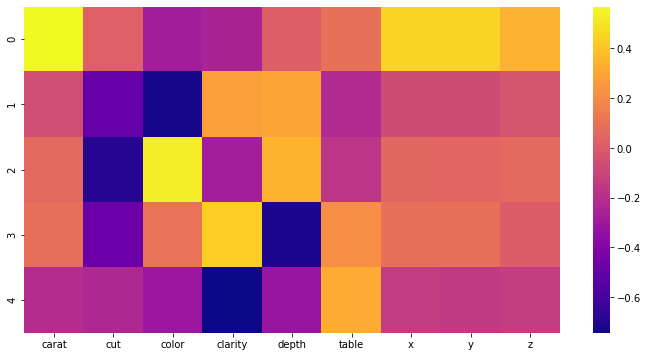

In [487]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

In [491]:
cols=['carat','cut','color','clarity','depth']
X1=df[cols]
Y1=df['price']
regression_model = LinearRegression()
regression_model.fit(X1,Y1 )
print("Accuracy score for the PCA components:")
regression_model.score(X1,Y1)

Accuracy score for the PCA components:


0.9291625647089187

# Train Test split

In [412]:
#random_state is the seed used by the random number generator, it can be any integer.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

In [413]:
X_train = sm.add_constant(X_train)
# create a fitted model in one line
lm_1 = sm.OLS(y_train,X_train).fit()

In [414]:
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 2.808e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:31:14   Log-Likelihood:                 21237.
No. Observations:               18853   AIC:                        -4.245e+04
Df Residuals:                   18843   BIC:                        -4.237e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1704      0.013    -13.395      0.0

In [415]:
vif_cal(input_data=df, dependent_col="price")

,Var,Vif
6,x,1562.88
7,y,1542.56
8,z,353.60
0,carat,81.93
4,depth,14.17
5,table,9.86
1,cut,7.57
2,color,5.46
3,clarity,5.25


# Building model-2 


Building model-2
Observation: (VIF values should be between 0 and 5)
x -> vif=1562.88 (high VIF value) hence we will remove x.

In [416]:
zirconia_for_m2_df = df.loc[:,df.columns!='x']

X_m2,y_m2 = get_feature_variable(zirconia_for_m2_df,'price')

#random_state is the seed used by the random number generator, it can be any integer.
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(X_m2, y_m2, train_size=0.7 ,test_size = 0.3, random_state=100)


X_train_m2 = sm.add_constant(X_train_m2)
lm_2 = sm.OLS(y_train_m2,X_train_m2).fit()
print(lm_2.summary())

        

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 3.150e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:32:01   Log-Likelihood:                 21212.
No. Observations:               18853   AIC:                        -4.241e+04
Df Residuals:                   18844   BIC:                        -4.234e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1420      0.012    -11.765      0.0

In [417]:
vif_cal(input_data=zirconia_for_m2_df, dependent_col="price")

,Var,Vif
6,y,342.95
7,z,342.25
0,carat,75.48
4,depth,13.93
5,table,9.81
1,cut,7.39
2,color,5.45
3,clarity,5.09


Building Model-3
Observation:
All P values are < 0.05,
VIF value of y->342.95

In [418]:
# remove y
m3_col = list(zirconia_for_m2_df.columns)
zirconia_for_m3_df = zirconia_for_m2_df.loc[:,zirconia_for_m2_df.columns!='y']

X_m3,y_m3 = get_feature_variable(zirconia_for_m3_df,'price')

#random_state is the seed used by the random number generator, it can be any integer.
X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(X_m3, y_m3, train_size=0.7 ,test_size = 0.3, random_state=100)


X_train_m3 = sm.add_constant(X_train_m3)
lm_3 = sm.OLS(y_train_m3,X_train_m3).fit()
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 3.588e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:32:54   Log-Likelihood:                 21184.
No. Observations:               18853   AIC:                        -4.235e+04
Df Residuals:                   18845   BIC:                        -4.229e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2130      0.008    -28.178      0.0

In [419]:
vif_cal(input_data=zirconia_for_m3_df, dependent_col="price")

,Var,Vif
6,z,94.66
0,carat,27.39
5,table,9.22
4,depth,7.62
1,cut,7.25
2,color,5.34
3,clarity,4.58


Building Model-4
Observation
All P values are < 0.05,
Z vif= 94.66

In [420]:
# remove z
m4_col = list(zirconia_for_m3_df.columns)
zirconia_for_m4_df = zirconia_for_m3_df.loc[:,zirconia_for_m3_df.columns!='z']

X_m4,y_m4 = get_feature_variable(zirconia_for_m4_df,'price')

#random_state is the seed used by the random number generator, it can be any integer.
X_train_m4, X_test_m4, y_train_m4, y_test_m4 = train_test_split(X_m4, y_m4, train_size=0.7 ,test_size = 0.3, random_state=100)


X_train_m4 = sm.add_constant(X_train_m4)
lm_4 = sm.OLS(y_train_m4,X_train_m4).fit()
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 4.154e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:33:29   Log-Likelihood:                 21115.
No. Observations:               18853   AIC:                        -4.222e+04
Df Residuals:                   18846   BIC:                        -4.216e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2900      0.004    -76.165      0.0

In [421]:
vif_cal(input_data=zirconia_for_m4_df, dependent_col="price")

,Var,Vif
5,table,7.40
1,cut,6.47
4,depth,4.53
2,color,4.42
3,clarity,3.85
0,carat,3.02


Building Model-5
Observation
table vif=7.40

In [422]:
# remove table
m5_col = list(zirconia_for_m4_df.columns)
zirconia_for_m5_df = zirconia_for_m4_df.loc[:,zirconia_for_m4_df.columns!='table']
X_m5,y_m5 = get_feature_variable(zirconia_for_m5_df,'price')

#random_state is the seed used by the random number generator, it can be any integer.
X_train_m5, X_test_m5, y_train_m5, y_test_m5 = train_test_split(X_m5, y_m5, train_size=0.7 ,test_size = 0.3, random_state=100)

X_train_m5 = sm.add_constant(X_train_m5)
lm_5 = sm.OLS(y_train_m5,X_train_m5).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 4.924e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:34:04   Log-Likelihood:                 21008.
No. Observations:               18853   AIC:                        -4.200e+04
Df Residuals:                   18847   BIC:                        -4.196e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3187      0.003    -97.098      0.0

In [423]:
vif_cal(input_data=zirconia_for_m5_df, dependent_col="price")

,Var,Vif
1,cut,5.43
4,depth,4.53
2,color,4.00
3,clarity,3.70
0,carat,2.52


VIF<=5 which means no Multicollinearity. Best 5 attributes that are most important are identified as "carat,color,cut,depth and clarity"  

# Making Predictions


In [424]:
regr = LinearRegression()
# Adding a constant variable 
X_test_m5 = sm.add_constant(X_test_m5)

regr.fit(X_train_m5,y_train_m5)
y_pred_m5 = regr.predict(X_test_m5)

print('Intercept of the model:',regr.intercept_)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error : %.2f'
      % mean_squared_error(y_test_m5, y_pred_m5))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test_m5, y_pred_m5))

print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test_m5, y_pred_m5)))


Intercept of the model: -0.3186851296442008
Coefficients: 
 [ 0.          1.2412458   0.02161192  0.1419318   0.27786614 -0.01472241]
Mean squared error : 0.01
Coefficient of determination: 0.93
RMSE : 0.07895506362313212


In [425]:
dfc = pd.DataFrame({'Actual': y_test_m5, 'Predicted': y_pred_m5})
dfc
#Though our model is not very precise, the predicted percentages are close to the actual ones

,Actual,Predicted
5478,0.059589,-0.035883
5347,0.050230,0.016564
16648,0.128365,0.149841
6630,0.203580,0.269958
11947,0.071094,0.056000
...,...,...
3811,0.051689,0.010013
26828,0.075473,0.151763
668,1.000000,0.851548
5295,0.396085,0.413803


plt.scatter(X_train_m5, y_train_m5, color = "red")
plt.plot(X_train_m5[:,0], regr.predict(X_train_m5), color = "green")
plt.title("Salary vs Experience (Training set)")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.show()

Model Evaluation


Text(0, 0.5, 'y_pred')

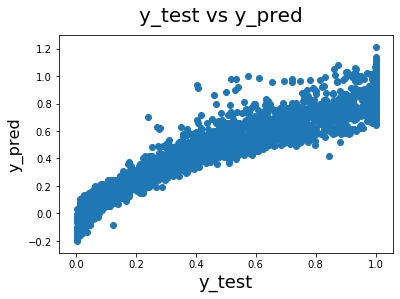

In [426]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test_m5,y_pred_m5)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)   

# Residual plot

Text(0, 0.5, 'Index')

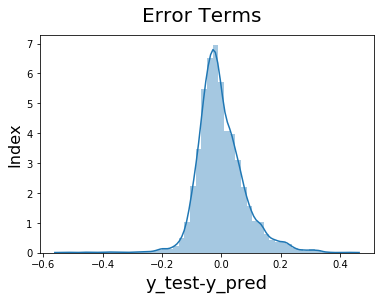

In [427]:
 #Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test_m5-y_pred_m5),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

# RMSE value

In [428]:
rmse = np.sqrt(mean_squared_error(y_test_m5, y_pred_m5))

print("Root Mean Squared Error: ", rmse)
print("R2_score: ",r2_score(y_test_m5, y_pred_m5))
print("Mean Absolute Error:  ", mean_absolute_error(y_test_m5, y_pred_m5))

Root Mean Squared Error:  0.07895506362313212
R2_score:  0.929711634798234
Mean Absolute Error:   0.05845568767995764


In [429]:
for i,j in np.array(lm_5.params.reset_index()):
    print('({}) * {} +'.format(round(j,2),i),end=' ')

(-0.32) * const + (1.24) * carat + (0.02) * cut + (0.14) * color + (0.28) * clarity + (-0.01) * depth + 

Model-5 Observation
ra
Assumptions of Linear Regression
I can see a good model with R-Square = 0.905
I can see good adjusted R-Squared = 0.905
As R-Squared and adjusted R-Squared is very close, we can assume none of the other variable need to add into the model as predictor. 
RMSE value is 0.09, lower the RMSE better the model performance, also we can see in above distribution the residual is around 0
Model have Durbin-Watson:1.995 which is between 0 and 4, we can assume there is no Autocorrelation
As we can see VIF<5 which means no Multicollinearity
P value is less the 0.05 which means they are highly significant variable. 

Result
The price of zirconia stone depends on attributes - carat, cut, color, clarity and depth

High profit vs Low profit: It is based on carat (High %), clarity(Medium %), color(Low %) and cut(very low%)
